In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 08 2018

@author: ncaplar@princeton.edu

"""
%connect_info

{
  "stdin_port": 61765, 
  "ip": "127.0.0.1", 
  "control_port": 61766, 
  "hb_port": 61767, 
  "signature_scheme": "hmac-sha256", 
  "key": "0b3866c1-b225afb63e2b79411d593e42", 
  "kernel_name": "", 
  "shell_port": 61763, 
  "transport": "tcp", 
  "iopub_port": 61764
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-a6f196d7-6c37-4f24-8d16-27d4ac634da6.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}



<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
#import statments
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import io
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

# Theoretical Analysis 

In [5]:
# load precomputed table of autocorrelation functions generated in Wolfram Mathematica notebook
ACFData=np.loadtxt(open('/Users/nevencaplar/Documents/Variability/MainSequence/ACFTable.csv', "rb"), delimiter=",", skiprows=0)

In [14]:
tau=np.unique(ACFData[:,0])
slope=np.unique(ACFData[:,1])
time=np.unique(ACFData[:,2])
ACF=ACFData[:,3]

print('avaliable tau are: '+str(tau))
print('avaliable slopes are: '+str(slope))
print('largest avaliable time is: '+str(max(time)))

avaliable tau are: [  10.       21.379    45.7088  100.      213.79  ]
avaliable slopes are: [ 1.25  1.5   1.75  2.    2.25  2.5   2.75]
largest avaliable time is: 600.0


In [8]:
# constructing multi-index panda dataframe (series)
mi = pd.MultiIndex.from_product([tau, slope, time], names=['tau', 'slope', 'time'])

#connect multiindex to data and save as multindexed series
sr_multi = pd.Series(index=mi, data=ACF.flatten())

## Looking at ACF

In [23]:
def get_ACF(tau,slope):
    """!gives autocorrelation function as a 2d numpy array [time, ACF]

    @param[in] tau          Decorellation time
    @param[in] slope        high frequency slope of the PSD



    """
    
    #pull out a dataframe with tau = 100 time units (see all options above)
    select_tau=sr_multi.xs(tau, level='tau').unstack(level=0)
    #pull out a dataframe with slope = 2
    select_tau_and_slope=select_tau[slope]
    
    res=[]
    for j in range(1,len(select_tau_and_slope.values)):
        res.append([j,select_tau_and_slope.values[j]])
    
    res=np.array(res)
    return res

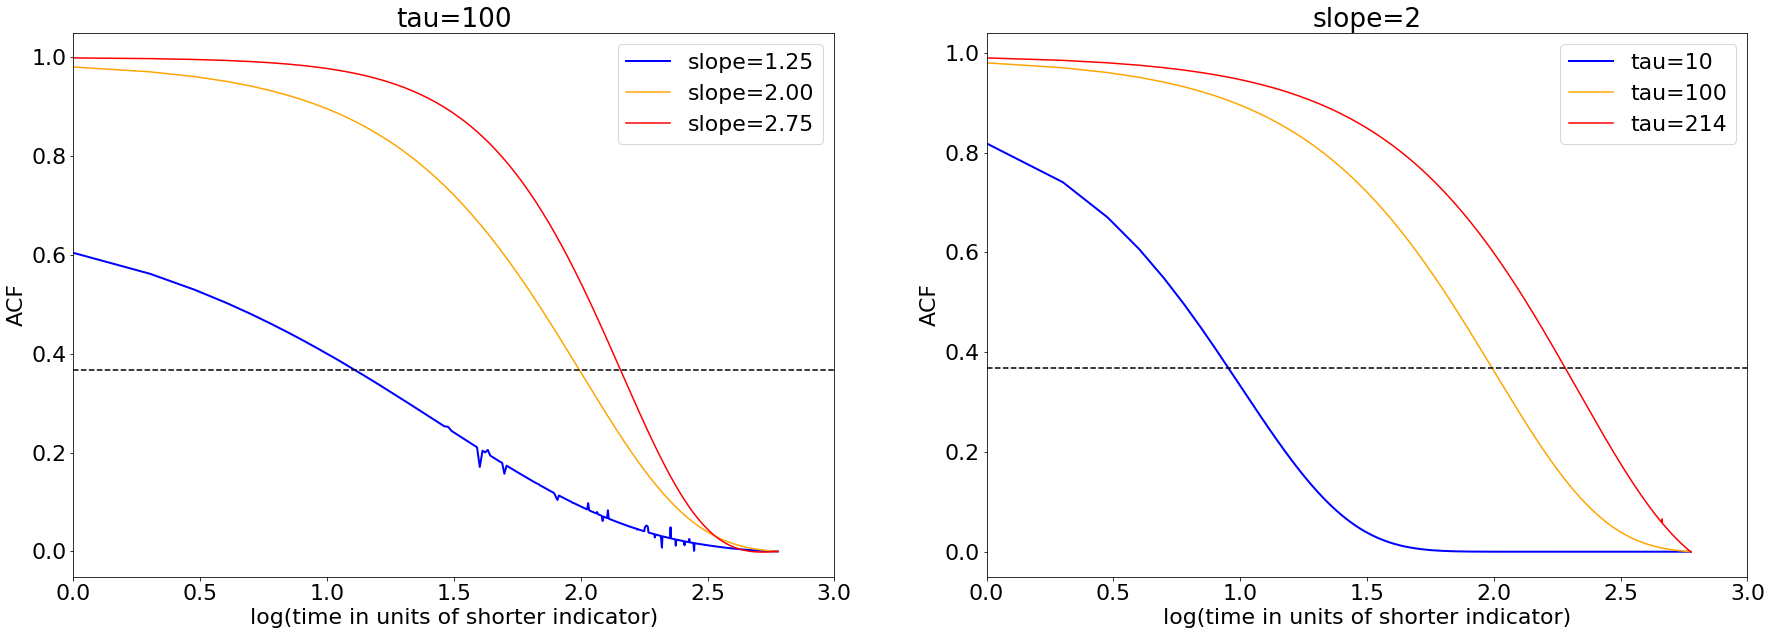

In [79]:
"""
Example showing how ACF depend on slope and tau
For slope 2 (damped random walk) we know the exact result that ACF(t)=exp(-t/tau)
We can verify below that ACF(100)=1/exp(-1) for the case of slope=2
"""
plt.figure(figsize=(30,10))

plt.subplot(121)

ACF_Example1=get_ACF(100,1.25)
ACF_Example2=get_ACF(100,2)
ACF_Example3=get_ACF(100,2.75)

plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='blue',label='slope=1.25',lw=2,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='orange',label='slope=2.00')
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='red',label='slope=2.75')

plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('ACF')
plt.title('tau=100')
plt.legend(fontsize=22)


plt.subplot(122)
ACF_Example1=get_ACF(10,2)
ACF_Example2=get_ACF(100,2)
ACF_Example3=get_ACF(213.79,2)

plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='blue',label='tau=10',lw=2,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='orange',label='tau=100')
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='red',label='tau=214')

plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('ACF')
plt.title('slope=2')
plt.legend(fontsize=22)

## scatter of the main sequence 

In [72]:
def get_scatter_MS(tau,slope,tMax=None):
    """!gives size of scatter as a 2d numpy array [time, scatter]

    @param[in] tau          Decorellation time
    @param[in] slope        high frequency slope of the PSD
    @param[in] tmax         what is the largest time that you want to consider (see 'largest avaliable time is' above);


    """
    if tMax is None:
        tMax=int(max(time))
    
    ACF=get_ACF(tau,slope)
    
    res=[]
    for t in range(1,tMax):
        res.append([t,(1+2*np.sum(((1-np.array(range(1,t+1))/t))*ACF[:,1][:t]))**(1/2)*(1/(t**(1/2)))])

    res=np.array(res)
    return res

In [69]:
    ACF=get_ACF(100,2)
    tMax=100
    res=[]
    (1+2*np.sum(((1-np.array(range(1,t+1))/t))*ACF[:,1][:t]))

1.9801482125895353

In [67]:
np.array(range(1,t+1))

array([1, 2])

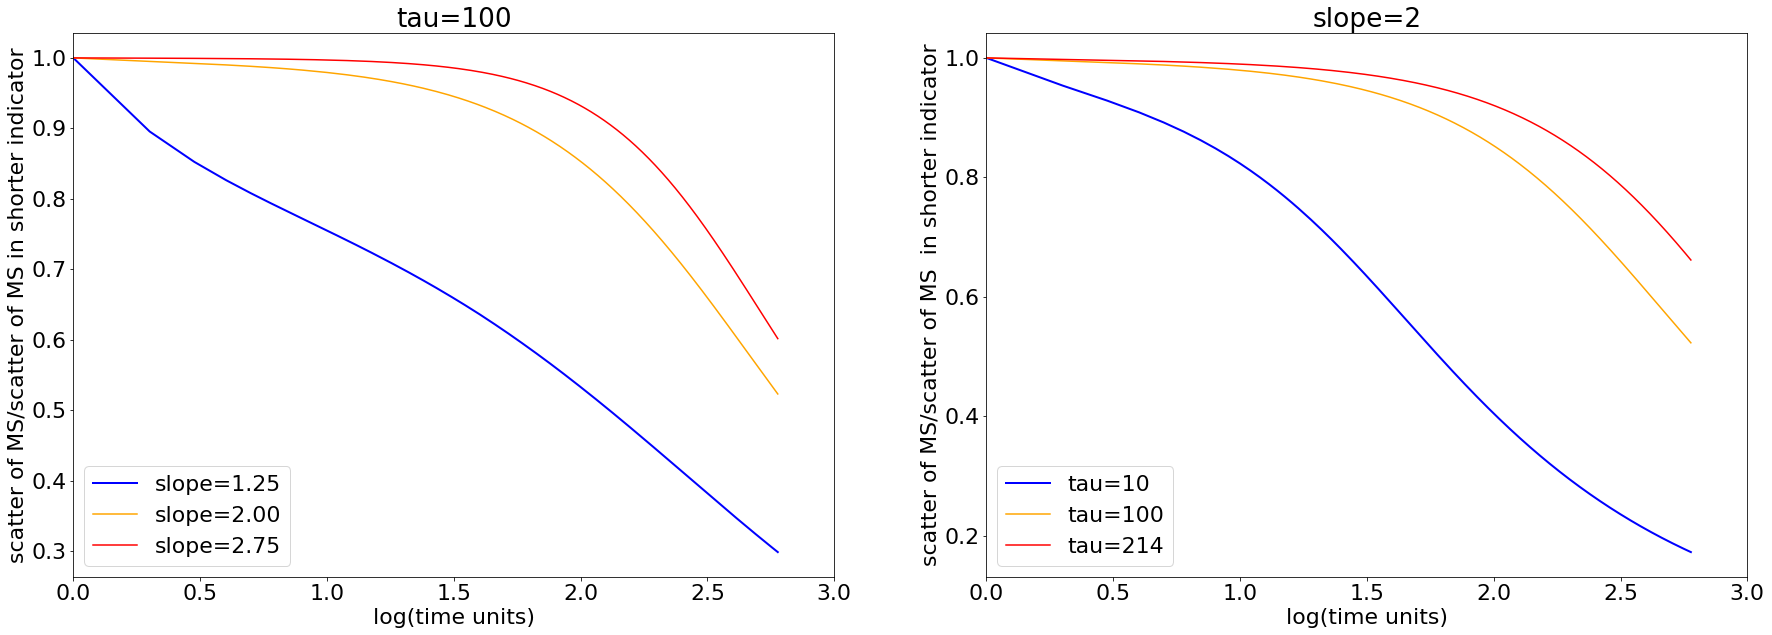

In [77]:
"""
Example showing how scatter depend on slope and tau 
"""
plt.figure(figsize=(30,10))

plt.subplot(121)

Scatter_Example1=get_scatter_MS(100,1.25)
Scatter_Example2=get_scatter_MS(100,2)
Scatter_Example3=get_scatter_MS(100,2.75)

plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='blue',label='slope=1.25',lw=2,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='orange',label='slope=2.00')
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='red',label='slope=2.75')

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator )')
plt.ylabel('scatter of MS/scatter of MS in shorter indicator')
plt.title('tau=100')
plt.legend(fontsize=22)


plt.subplot(122)
Scatter_Example1=get_scatter_MS(10,2)
Scatter_Example2=get_scatter_MS(100,2)
Scatter_Example3=get_scatter_MS(213.79,2)

plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='blue',label='tau=10',lw=2,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='orange',label='tau=100')
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='red',label='tau=214')

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('scatter of MS/scatter of MS  in shorter indicator')
plt.title('slope=2')
plt.legend(fontsize=22)

## Mean relation 

In [83]:
def get_mean_relation(tau,slope,tMax=None):
    """!gives ratio between mean SFR of a longer indicator and the SFR in a shorten indicator [time, ratio of two indicators ]
        assumes nonchanging mean sequence!

    @param[in] tau          Decorellation time
    @param[in] slope        high frequency slope of the PSD
    @param[in] tmax         what is the largest time that you want to consider (see 'largest avaliable time is' above);


    """
    if tMax is None:
        tMax=int(max(time))
    
    ACF=get_ACF(tau,slope)
    
    res=[]
    for t in range(1,tMax):
        res.append([t,np.sum(ACF[:,1][:t])/(t-1)])

    res=np.array(res)
    return res

/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


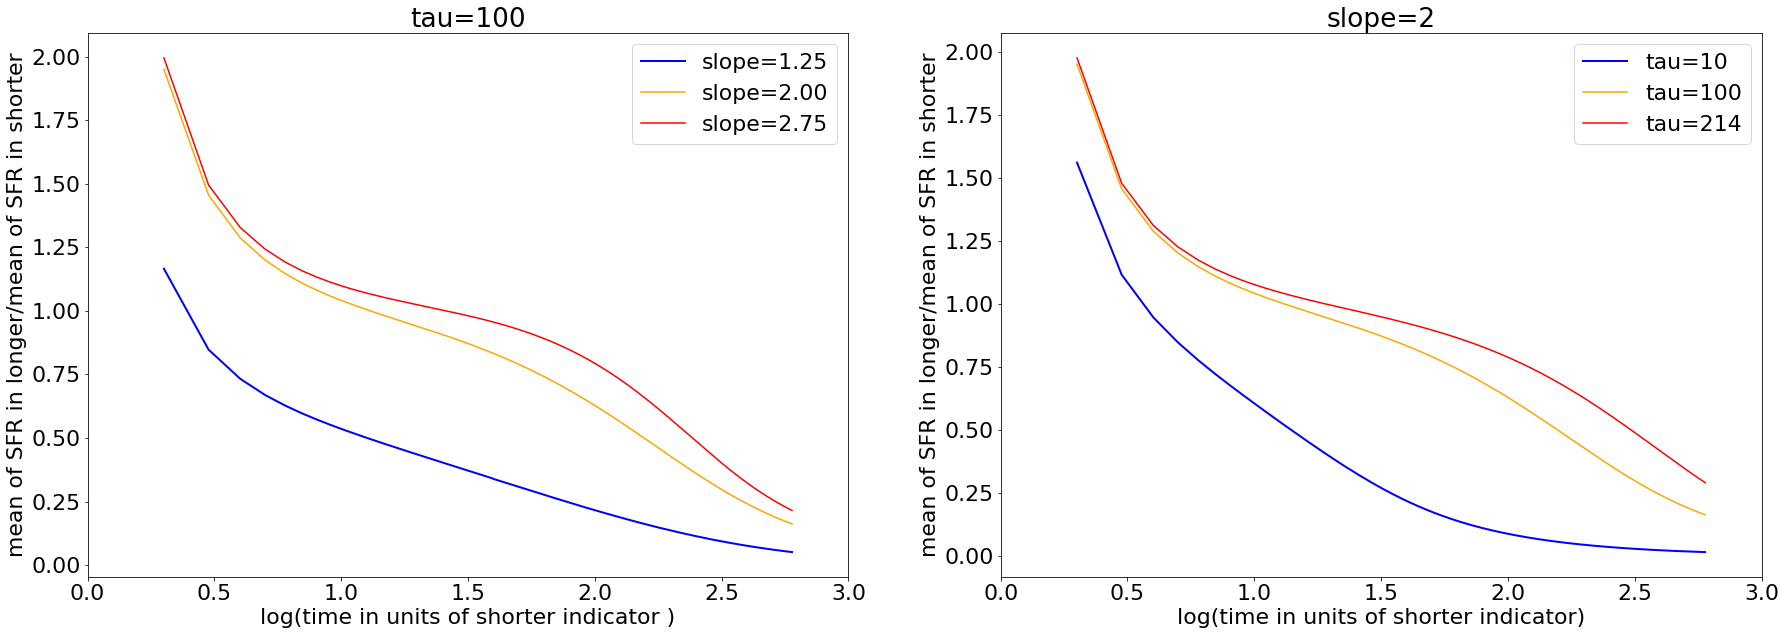

In [84]:
"""
Example showing how mean depend on slope and tau 
HM, larger than one!!!!! CHECK!!!!!
!!!!! CHECK!!!!!
!!!!! CHECK!!!!!
!!!!! CHECK!!!!!
!!!!! CHECK!!!!!
!!!!! CHECK!!!!!
!!!!! CHECK!!!!!
"""
plt.figure(figsize=(30,10))

plt.subplot(121)

Mean_Example1=get_mean_relation(100,1.25)
Mean_Example2=get_mean_relation(100,2)
Mean_Example3=get_mean_relation(100,2.75)

plt.plot(np.log10(Mean_Example1[:,0]),Mean_Example1[:,1],color='blue',label='slope=1.25',lw=2,linestyle='-')
plt.plot(np.log10(Mean_Example2[:,0]),Mean_Example2[:,1],color='orange',label='slope=2.00')
plt.plot(np.log10(Mean_Example3[:,0]),Mean_Example3[:,1],color='red',label='slope=2.75')

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator )')
plt.ylabel('mean of SFR in longer/mean of SFR in shorter')
plt.title('tau=100')
plt.legend(fontsize=22)


plt.subplot(122)
Mean_Example1=get_mean_relation(10,2)
Mean_Example2=get_mean_relation(100,2)
Mean_Example3=get_mean_relation(213.79,2)

plt.plot(np.log10(Mean_Example1[:,0]),Mean_Example1[:,1],color='blue',label='tau=10',lw=2,linestyle='-')
plt.plot(np.log10(Mean_Example2[:,0]),Mean_Example2[:,1],color='orange',label='tau=100')
plt.plot(np.log10(Mean_Example3[:,0]),Mean_Example3[:,1],color='red',label='tau=214')

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('mean of SFR in longer/mean of SFR in shorter')
plt.title('slope=2')
plt.legend(fontsize=22)

In [82]:
Mean_Example1

array([        inf,  1.16601076,  0.84780193,  0.73290679,  0.66982426,
        0.62802878,  0.59724711,  0.57300533,  0.5530269 ,  0.536021  ,
        0.52121055,  0.50804672,  0.49619259,  0.48539627,  0.47547254,
        0.46628149,  0.45771034,  0.44967841,  0.44211719,  0.43497088,
        0.42819337,  0.42174615,  0.41559671,  0.40971003,  0.40407711,
        0.39866969,  0.39346973,  0.38846139,  0.38363067,  0.37909766,
        0.37458177,  0.37021027,  0.36597418,  0.36186534,  0.35787638,
        0.35400093,  0.35023247,  0.34656537,  0.34299446,  0.3385829 ,
        0.33521348,  0.33192609,  0.32891729,  0.32577796,  0.32271026,
        0.31971119,  0.3167763 ,  0.31390371,  0.31109956,  0.30795987,
        0.30527269,  0.30263929,  0.30005773,  0.29752619,  0.29504294,
        0.29260634,  0.29021483,  0.28786716,  0.2855617 ,  0.28329713,
        0.28107216,  0.27888559,  0.27673626,  0.27462307,  0.27254497,
        0.27050094,  0.26849002,  0.26652097,  0.26457315,  0.26

In [ ]:
#slope for mean
Nmax=100
np.sum(select_tau_and_slope.values[:Nmax])/(Nmax-1)

In [38]:
#slope for mean
Nmax=100
np.sum(ACF[:,1][:t])/(t-1)

array([ 0.36787944,  0.36787944,  0.36787944,  0.36787944,  0.36787944,
        0.36787944,  0.36787944,  0.36787944,  0.36787944,  0.36787944])

In [37]:
np.exp[1]

TypeError: 'numpy.ufunc' object has no attribute '__getitem__'

# Example with generated data 